## GARBAGE CLASSIFICATION

The accumulation of solid waste in the urban area is becoming a great concern, and it would result in environmental pollution and may be hazardous to human health if it is not properly managed. It is important to have an advanced/intelligent waste management system to manage a variety of waste materials. One of the most important steps of waste management is the separation of the waste into the different components and this process is normally done manually by hand-picking. Convolutional Neural Network model which is used to classify the waste into different groups/types such as glass, metal, paper, and plastic etc. The proposed system is tested on the trash image dataset which was developed by Gary Thung and Mindy Yang, and is able to achieve an accuracy of 92% on the dataset. The separation process of the waste will be faster and intelligent using the proposed waste material classification system without or reducing human involvement.



## Building an image classifier

In this project,by using the convolutional neural network to classify an image as either cardboard, glass, metal, paper, plastic, or trash. The image dataset collected manually by Gary Thung and Mindy Yang was used here. 

#### Modeling pipeline:

1. Download and extract the images
2. Organize the images into different folders
3. Train model
4. Make and evaluate test predictions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

## 1. Extract data

First, we need to extract the contents of "dataset-resized.zip".

In [3]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

Once unzipped, the dataset-resized folder has six subfolders:

In [11]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['paper', 'trash', '.DS_Store', 'cardboard', 'metal', 'glass', 'plastic']

## 2. Organize images into different folders

After extracting the images the split images into train, validation, and test image folders with a 50-25-25 split. 

In [12]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Next, a bunch of destination folders was created according to the ImageNet directory convention. It'll look like this:

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Each image file is just the material name and a number (i.e. cardboard1.jpg)

Again, this is just housekeeping to organize my files.

In [13]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

I set the seed for both random samples to be 1 for reproducibility. Now that the data's organized, we can get to model training.

In [14]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/home/jupyter/data')

In [15]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

The batch size bs is how many images you'll train at a time. Choose a smaller batch size if your computer has less memory. 

You can use get_transforms() function to augment your data. The results will be compared from flipping images horizontally and vertically.

In [16]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageItemList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /home/jupyter/data;

Valid: LabelList (630 items)
x: ImageItemList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /home/jupyter/data;

Test: LabelList (635 items)
x: ImageItemList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /home/jupyter/data

In [17]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Here's an example of what the data looks like:

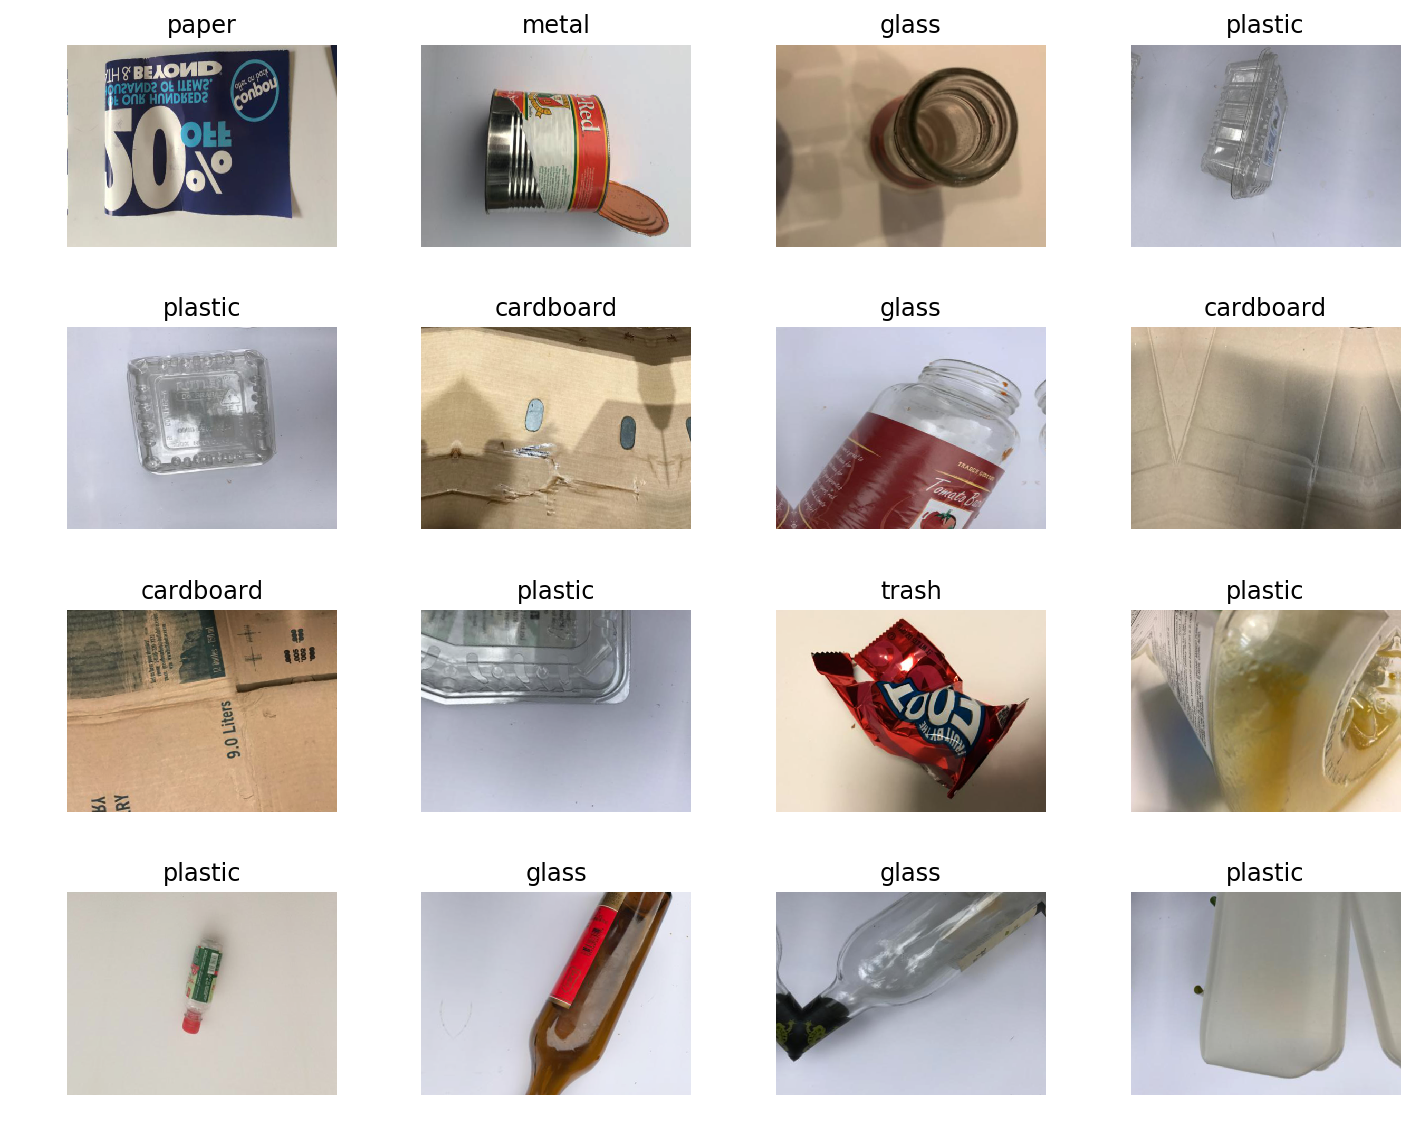

In [18]:
data.show_batch(rows=4,figsize=(10,8))

## 3. Model training

In [19]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

### Convolutional Neural Network CNN (resnet34)

A residual neural network is a Convolutional Neural Network CNN with lots of layers. In particular, resnet34 is a CNN with 34 layers that's been pretrained on the Image database.  A pretrained CNN will perform better on new image classification tasks because it has already learned some visual features and can transfer that knowledge over (hence transfer learning).

Since they're capable of describing more complexity, deep neural networks should theoretically perform better than shallow networks on training data. In reality, though, deep neural networks tend to perform empirically worse than shallow ones. 

Resnets were created to circumvent this glitch using a hack called shortcut connections. If some nodes in a layer have suboptimal values, you can adjust weights and bias; if a node is optimal (its residual is 0), why not leave it alone? Adjustments are only made to nodes on an as-needed basis (when there's non-zero residuals). 

When adjustments are needed, shortcut connections apply the identity function to pass information to subsequent layers. This shortens the neural network when possible and allows resnets to have deep architectures and behave more like shallow neural networks. The 34 in resnet34 just refers to the number of layers.


In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### Finding a learning rate

We are going to find a learning rate for gradient descent to make sure that my neural network converges reasonably quickly without missing the optimal error.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.13E-03


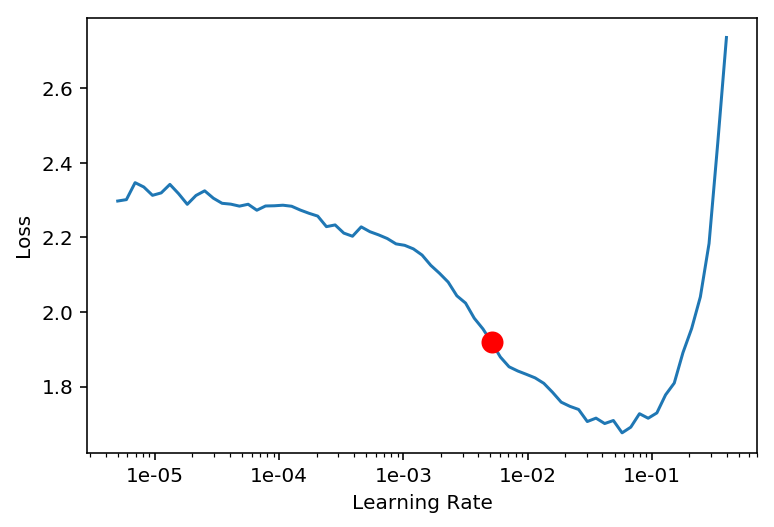

In [22]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

The learning rate finder suggests a learning rate of 5.13e-03. With this, we can train the model.

### Training

In [23]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate
1,1.422490,0.761797,0.247619
2,0.885877,0.511399,0.179365
3,0.708581,0.399528,0.131746
4,0.631002,0.613640,0.206349
5,0.654630,0.580892,0.200000
6,0.659428,0.520196,0.165079
7,0.605400,0.496592,0.192063
8,0.563043,0.474075,0.161905
9,0.567712,0.362857,0.126984
10,0.469160,0.405082,0.138095


I ran my model for 20 epochs. What's cool about this fitting method is that the learning rate decreases with each epoch, allowing us to get closer and closer to the optimum. At 8.6%, the validation error looks super good... let's see how it performs on the test data though. 


In [24]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

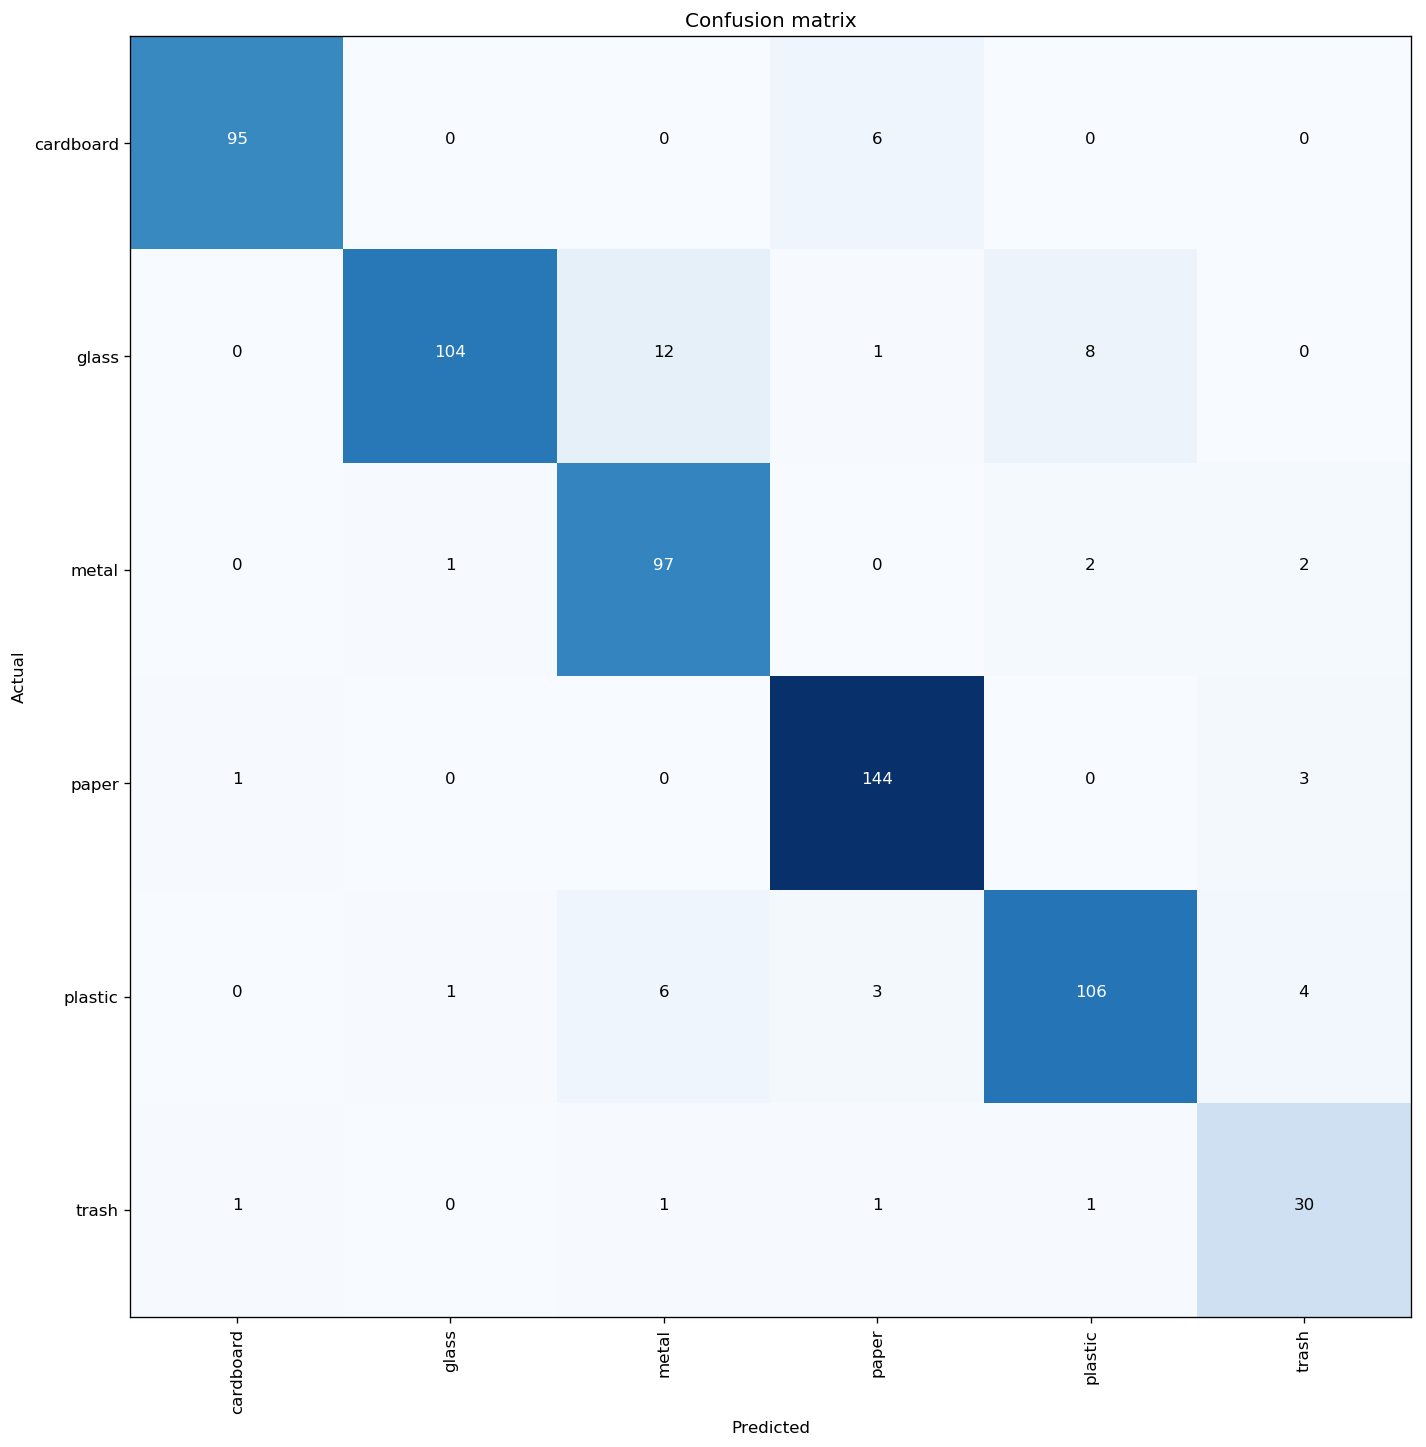

In [26]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


This model often confused plastic for glass and confused metal for glass. The list of most confused images is below.

In [27]:
interp.most_confused(min_val=2)

[('glass', 'metal', 12),
 ('glass', 'plastic', 8),
 ('cardboard', 'paper', 6),
 ('plastic', 'metal', 6),
 ('plastic', 'trash', 4),
 ('paper', 'trash', 3),
 ('plastic', 'paper', 3)]

## 4. Make new predictions on test data

To see how this mode really performs, we need to make predictions on test data. First, I'll make predictions on the test data using the learner.get_preds() method. 


In [28]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [29]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[8.9301e-05, 6.9159e-01, 6.6568e-03, 2.4916e-03, 2.9144e-01, 7.7287e-03],
        [3.2214e-07, 8.5046e-01, 1.4467e-01, 1.4697e-04, 3.7977e-03, 9.2930e-04],
        [6.3714e-06, 3.4552e-05, 4.4017e-03, 9.6305e-01, 2.7684e-03, 2.9743e-02],
        ...,
        [2.9191e-04, 2.7249e-05, 1.9705e-04, 9.6456e-01, 3.3750e-02, 1.1713e-03],
        [9.9844e-01, 8.7004e-04, 5.9910e-05, 5.2392e-04, 6.4409e-05, 4.5726e-05],
        [9.9987e-01, 3.4074e-06, 9.6142e-07, 1.1883e-04, 1.3097e-06, 2.4700e-06]])

These are the predicted probablities for each image. This tensor has 365 rows -- one for each image -- and 6 columns -- one for each material category.

In [30]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Now I'm going to convert the probabilities in the tensor above to a string with one of the class names.

In [31]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [32]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [33]:
yhat

['glass',
 'glass',
 'paper',
 'cardboard',
 'paper',
 'paper',
 'plastic',
 'plastic',
 'metal',
 'trash',
 'glass',
 'paper',
 'trash',
 'cardboard',
 'paper',
 'cardboard',
 'cardboard',
 'metal',
 'trash',
 'plastic',
 'plastic',
 'cardboard',
 'paper',
 'plastic',
 'metal',
 'metal',
 'cardboard',
 'metal',
 'metal',
 'plastic',
 'metal',
 'plastic',
 'paper',
 'plastic',
 'cardboard',
 'metal',
 'plastic',
 'paper',
 'cardboard',
 'glass',
 'metal',
 'paper',
 'cardboard',
 'plastic',
 'metal',
 'trash',
 'cardboard',
 'plastic',
 'plastic',
 'paper',
 'paper',
 'paper',
 'glass',
 'metal',
 'glass',
 'glass',
 'plastic',
 'paper',
 'cardboard',
 'plastic',
 'glass',
 'paper',
 'metal',
 'paper',
 'glass',
 'paper',
 'paper',
 'glass',
 'glass',
 'cardboard',
 'glass',
 'glass',
 'paper',
 'metal',
 'metal',
 'plastic',
 'plastic',
 'glass',
 'cardboard',
 'metal',
 'plastic',
 'plastic',
 'glass',
 'cardboard',
 'cardboard',
 'paper',
 'plastic',
 'paper',
 'metal',
 'glass',
 '

These are the predicted labels of all the images! Let's check if the first image is actually glass.

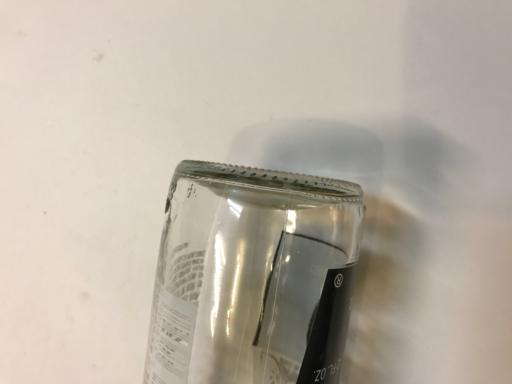

In [34]:
learn.data.test_ds[0][0]

It is!

Next, I'll get the actual labels from the test dataset.

In [35]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

A quick check.

In [36]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['glass', 'glass', 'paper', 'cardboard', 'paper']
['glass', 'glass', 'paper', 'cardboard', 'paper']


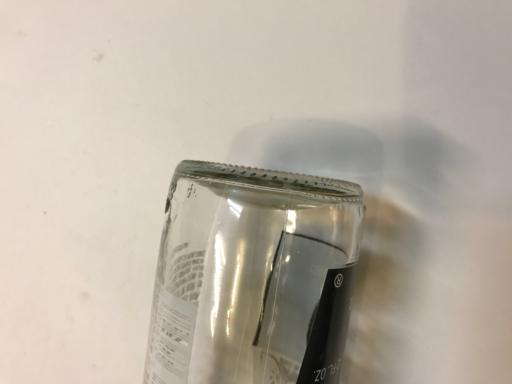

In [37]:
learn.data.test_ds[0][0]

It looks the first five predictions match up! (check)

How did we end up doing? Again we can use a confusion matrix to find out.

### Test confusion matrix

In [38]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 97   0   2   2   0   0]
 [  0 104  13   0   9   0]
 [  1   1  96   2   2   1]
 [  0   0   1 144   0   4]
 [  0   2   1   0 116   2]
 [  1   0   1   4   1  28]]


Let's try and make this matrix a little prettier.

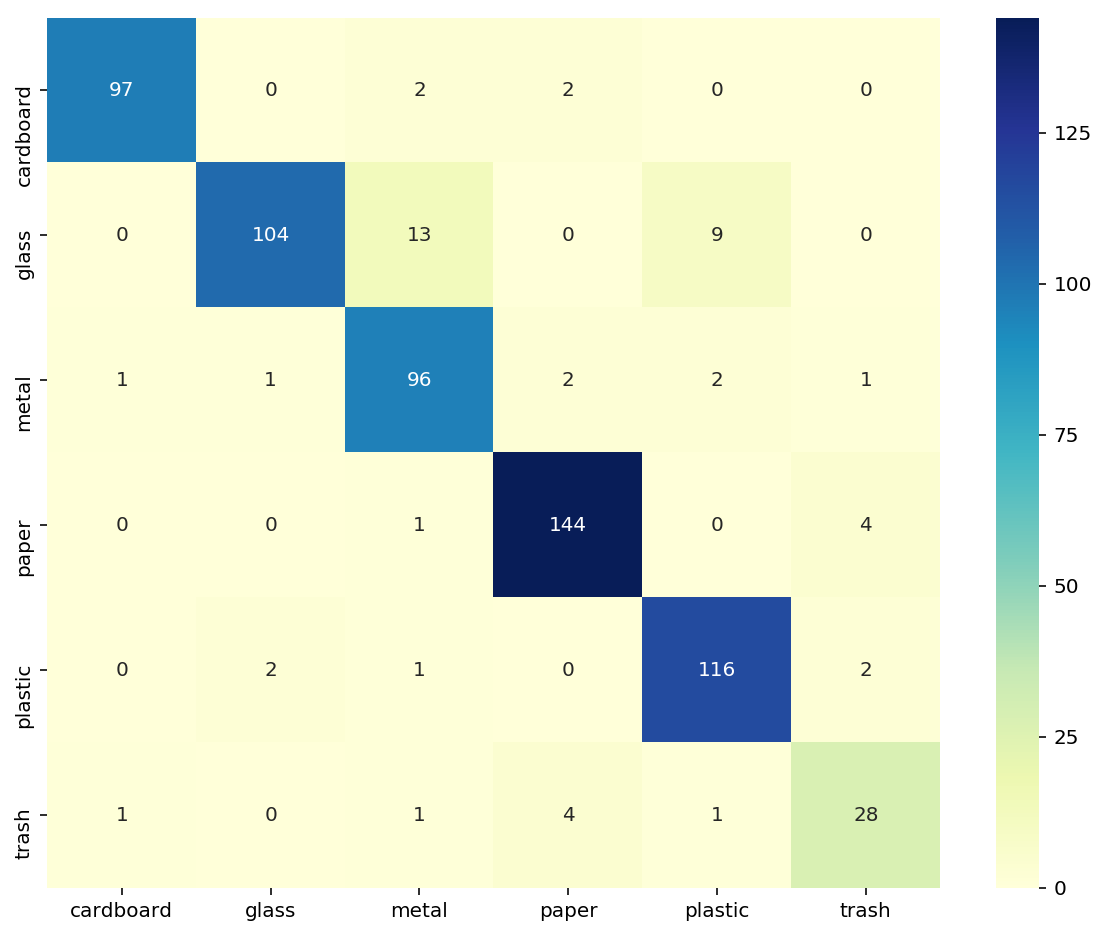

In [39]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [40]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [49]:
accuracy = correct/sum(sum(cm))
accuracy

0.9212598425196851

## 5. Accuracy

This CNN based Garbage Classification using Deep Learning provides an accuracy of 92.1% on the test data. 

In [50]:
## delete everything when you're done to save space
shutil.rmtree("data")
shutil.rmtree('dataset-resized')

## 6. Conclusion

A waste classification system that is able to separate different components of waste using the Machine learning tools was proposed. This system can be used to automatically classify waste and help in reducing human intervention and preventing infection and pollution. From the result, when tested against the trash dataset, we got an accuracy of 92.1%. The separation process of the waste will be faster and intelligent using our system without or reducing human involvement. If more image is added to the dataset, the system accuracy can be improved In the future, we will tend to improve our system to be able to categories more waste item, by turning some of the parameters used.